# notebooks.smart_microfluidics_visualizations

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import plotly.express as px
import scipy.cluster.hierarchy as sch
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [ ]:
file_path = 'data.csv'
data = pd.read_csv(file_path, encoding='latin1')
data = data.set_index('ID')
#print(data.info())

## Heatmaps

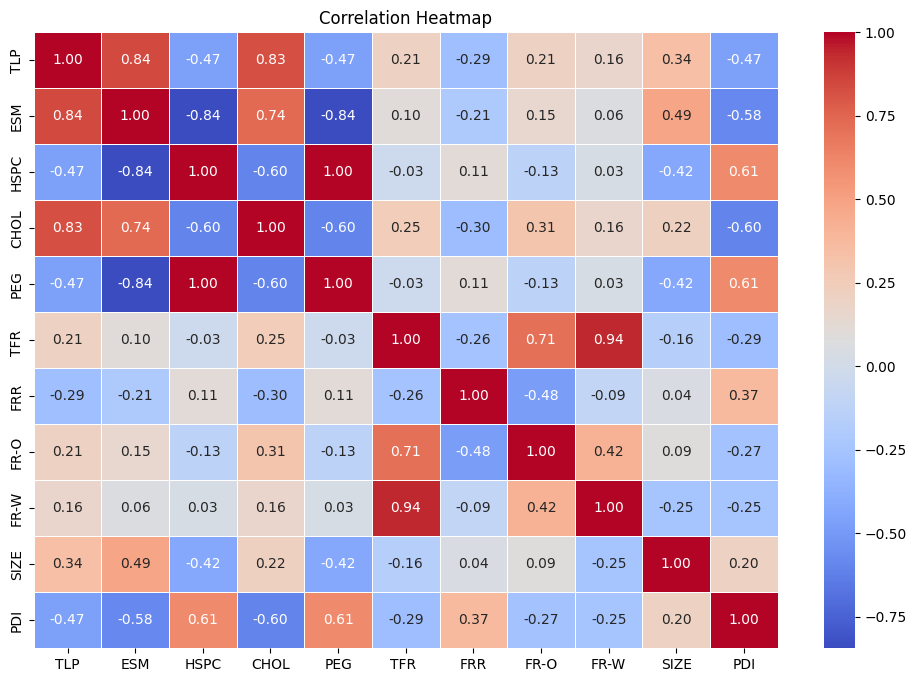

In [ ]:
numeric_cols = data.select_dtypes(include=['number']).columns
yes_data = data[data['OUTPUT'] == 'YES']
numeric_yes_data = yes_data[numeric_cols]
correlation_matrix = numeric_yes_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

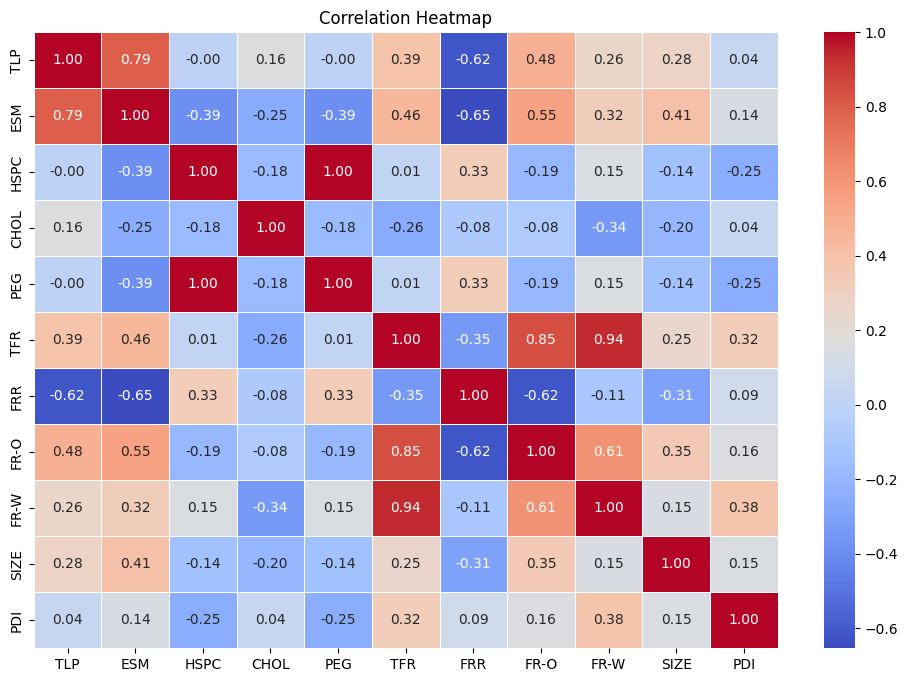

In [ ]:
numeric_cols = data.select_dtypes(include=['number']).columns
no_data = data[data['OUTPUT'] == 'NO']
numeric_no_data = no_data[numeric_cols]
correlation_matrix = numeric_no_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

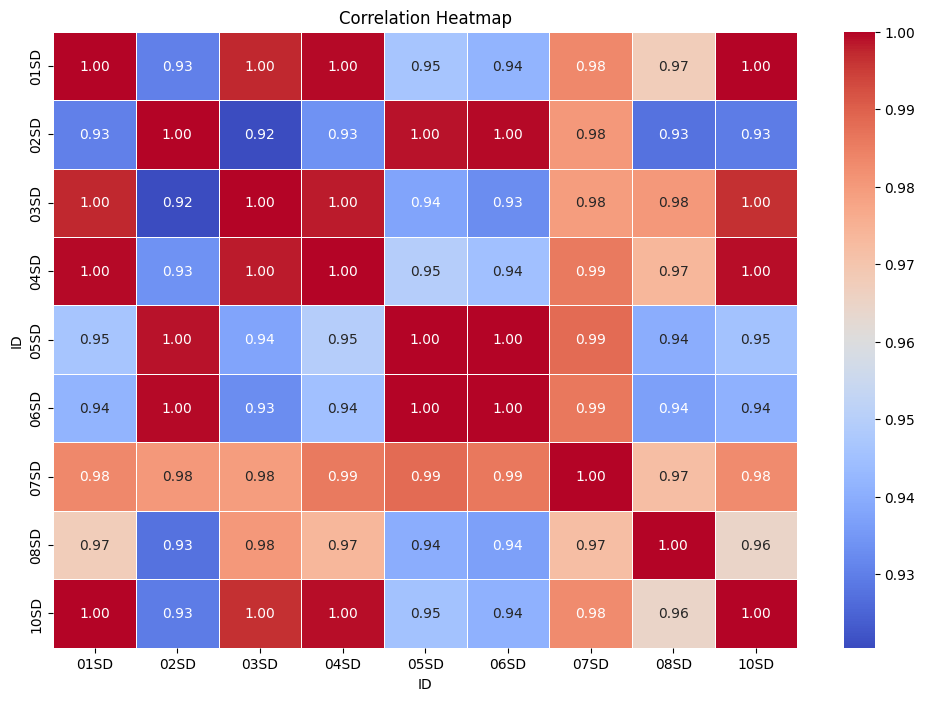

In [ ]:
data_red = data[:10]
numeric_cols = data_red.select_dtypes(include=['number']).columns
yes_data = data_red[data_red['OUTPUT'] == 'YES']
numeric_yes_data_red = yes_data[numeric_cols]
correlation_matrix = numeric_yes_data_red.T.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Clustered heatmaps

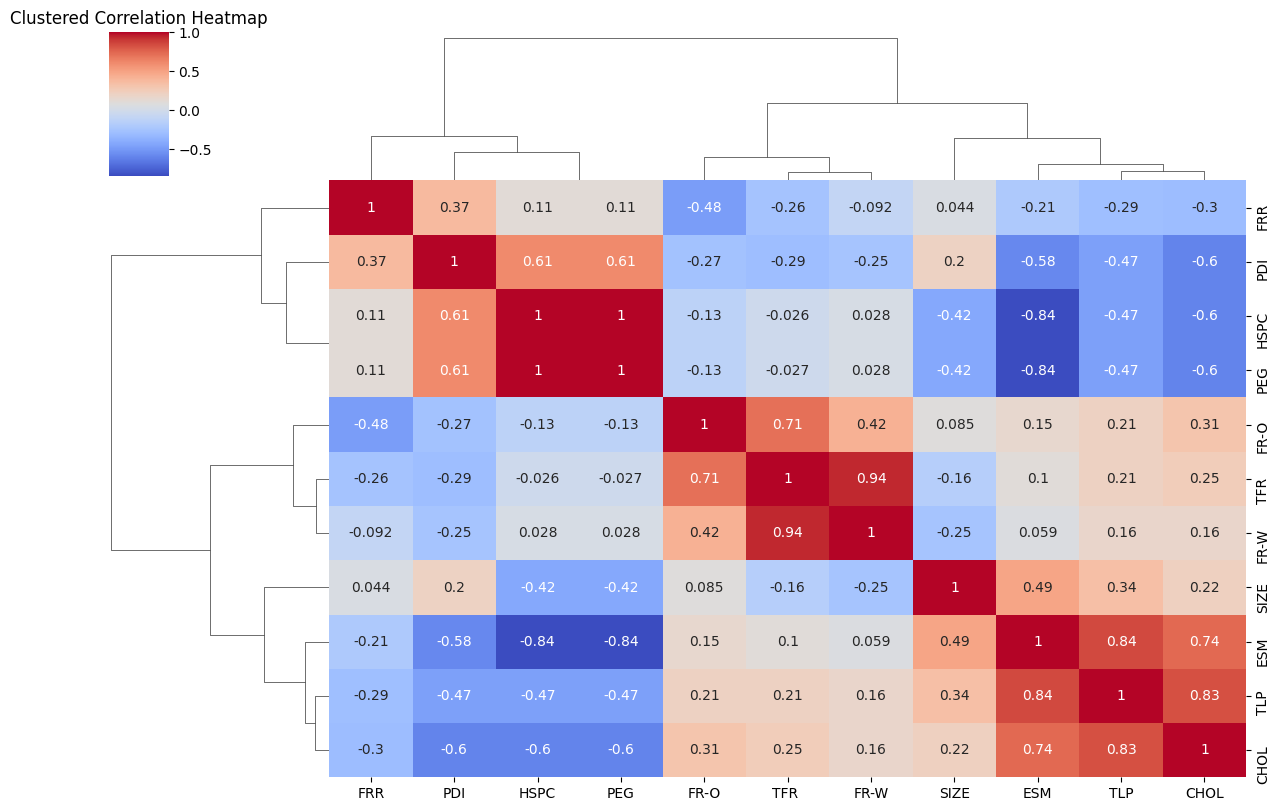

In [ ]:
linkage_matrix_no = sch.linkage(numeric_yes_data, method='ward')
sns.clustermap(
    numeric_yes_data.corr(),
    method='ward',
    cmap='coolwarm',
    annot=True,
    figsize=(12, 8)
)
plt.title("Clustered Correlation Heatmap")
plt.show()

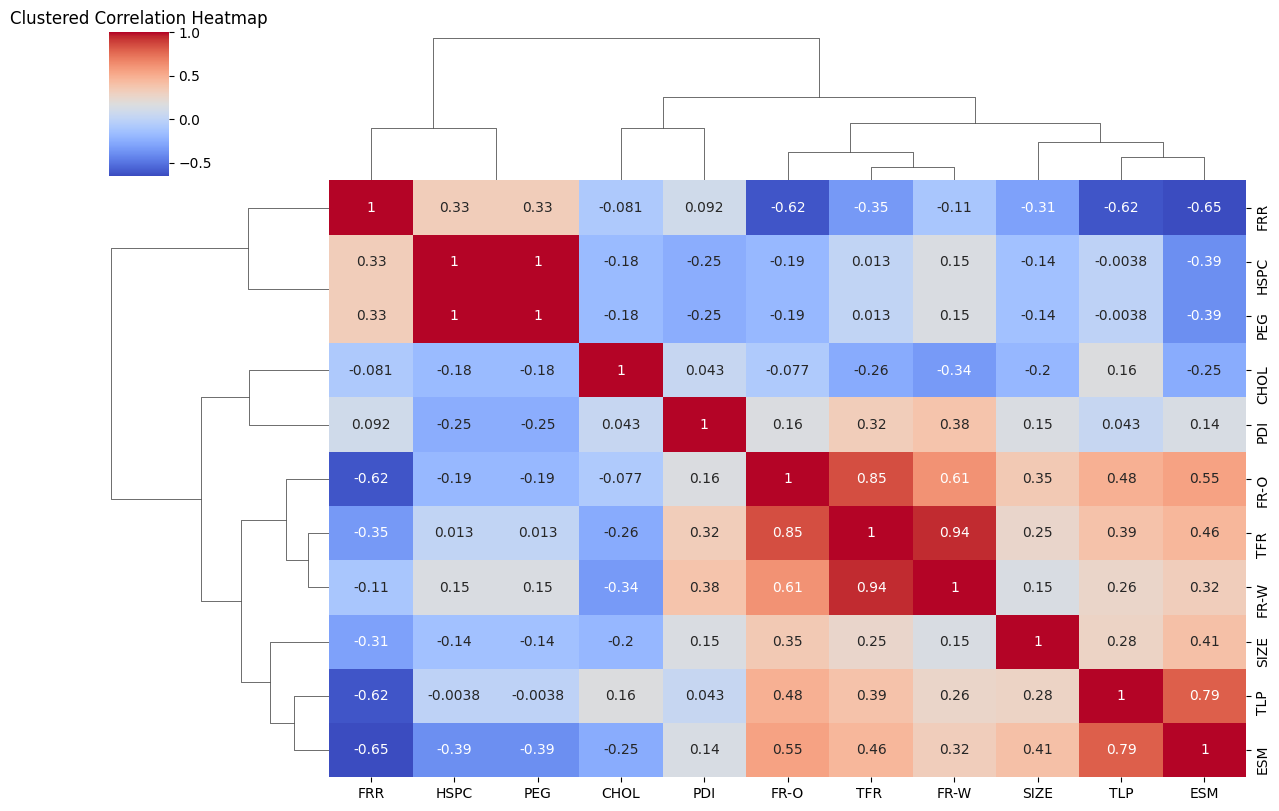

In [ ]:
linkage_matrix_no = sch.linkage(numeric_no_data, method='ward')
sns.clustermap(
    numeric_no_data.corr(),
    method='ward',
    cmap='coolwarm',
    annot=True,
    figsize=(12, 8)
)
plt.title("Clustered Correlation Heatmap")
plt.show()

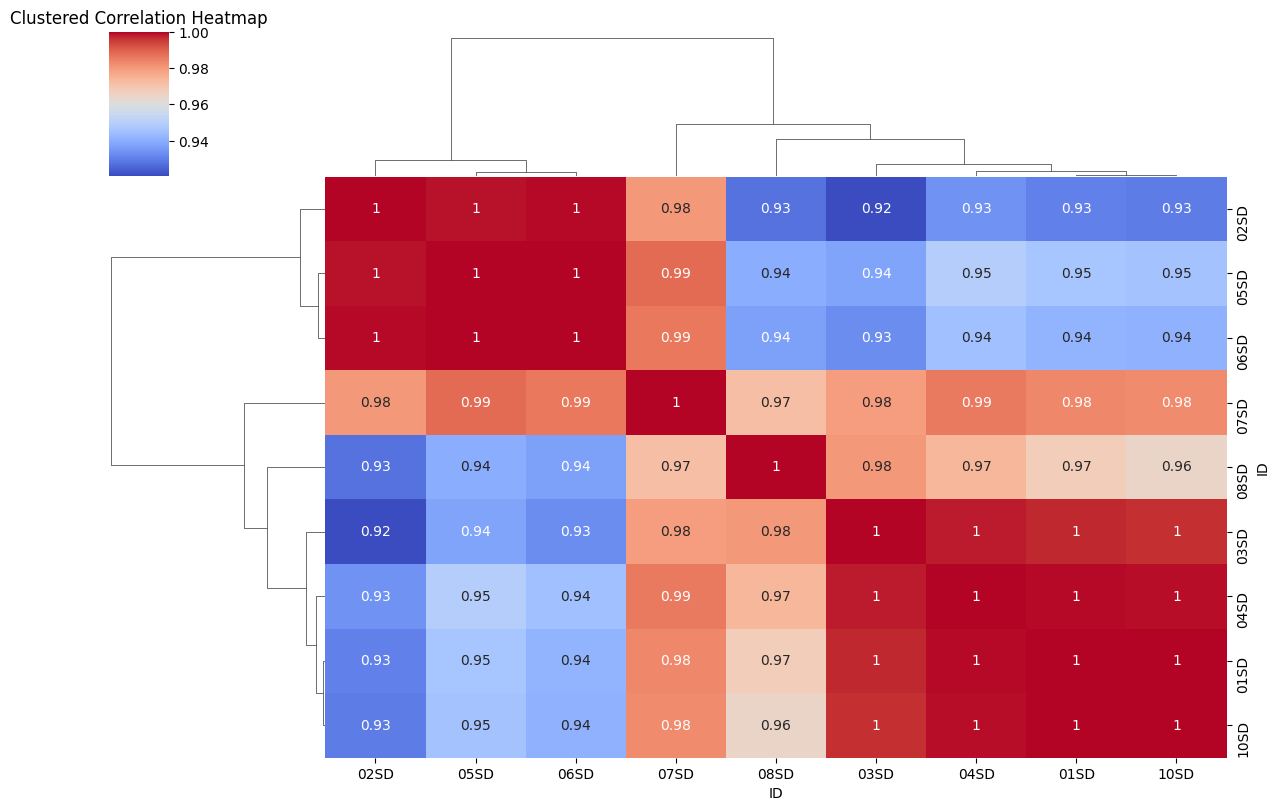

In [ ]:
linkage_matrix_no = sch.linkage(numeric_yes_data_red.T, method='ward')
sns.clustermap(
    numeric_yes_data_red.T.corr(),
    method='ward',
    cmap='coolwarm',
    annot=True,
    figsize=(12, 8)
)
plt.title("Clustered Correlation Heatmap")
plt.show()

## Alluvial plots

In [ ]:
value_counts = data.groupby(['ML', 'BUFFER']).size().reset_index(name='value')
categories = list(set(value_counts['ML']).union(set(value_counts['BUFFER'])))
category_to_index = {category: i for i, category in enumerate(categories)}
sources = value_counts['ML'].map(category_to_index).tolist()
targets = value_counts['BUFFER'].map(category_to_index).tolist()
values = value_counts['value'].tolist()
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=categories
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])
fig.update_layout(
    title_text="Alluvial Plot of Main Lipid to Buffer Flow",
    font_size=10
)
fig.show()

In [ ]:
value_counts = data.groupby(['ML', 'CHIP', 'BUFFER', 'OUTPUT']).size().reset_index(name='value')
all_categories = []
for col in ['ML', 'CHIP', 'BUFFER', 'OUTPUT']:
    all_categories.extend(value_counts[col].unique())
all_categories = list(set(all_categories))
category_to_index = {category: index for index, category in enumerate(all_categories)}
sources = []
targets = []
values = []
for index, row in value_counts.iterrows():
    sources.append(category_to_index[row['ML']])
    targets.append(category_to_index[row['CHIP']])
    values.append(row['value'])
    sources.append(category_to_index[row['CHIP']])
    targets.append(category_to_index[row['BUFFER']])
    values.append(row['value'])
    sources.append(category_to_index[row['BUFFER']])
    targets.append(category_to_index[row['OUTPUT']])
    values.append(row['value'])
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_categories
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(
    title_text="Sankey Diagram of ML->CHIP->BUFFER->OUTPUT Flow",
    font_size=10
)

fig.show()

## Feature importance with random forests

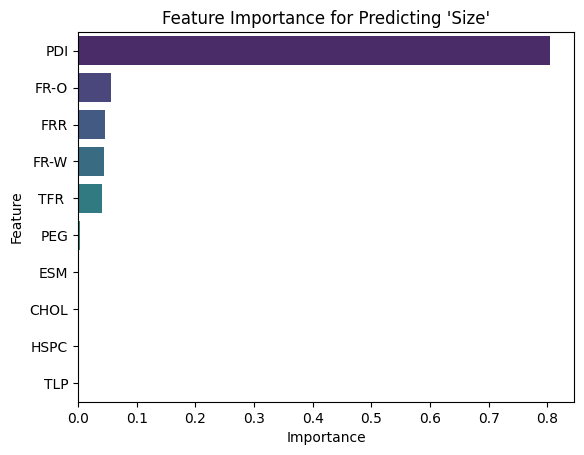

In [ ]:
numeric_data = data.select_dtypes(include=['float64', 'int64']).dropna()
X = numeric_data.drop(columns=['SIZE'])
y = numeric_data['SIZE']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=feature_importances, x='Importance', y='Feature',
            hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title("Feature Importance for Predicting 'Size'")
plt.show()

In [ ]:
numeric_data = data.select_dtypes(include=['float64', 'int64']).dropna()
X = numeric_data.drop(columns=['SIZE', 'PDI'])
y_size = numeric_data['SIZE']
y_pdi = numeric_data['PDI']

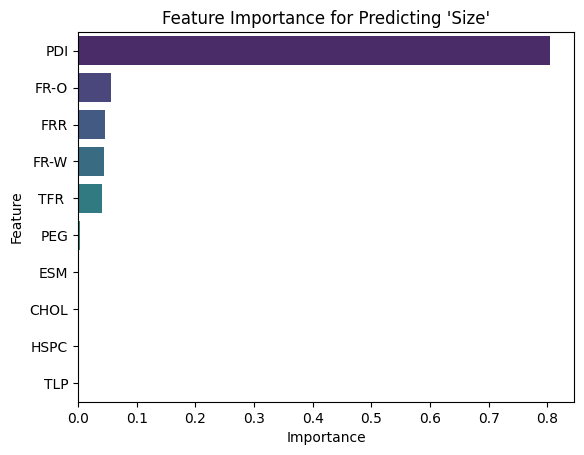

In [ ]:
rf_size = RandomForestRegressor(n_estimators=100, random_state=42)
rf_size.fit(X, y_size)
feature_importances_size = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_size.feature_importances_
}).sort_values(by='Importance', ascending=False)
sns.barplot(data=feature_importances, x='Importance', y='Feature',
            hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title("Feature Importance for Predicting 'Size'")
plt.show()


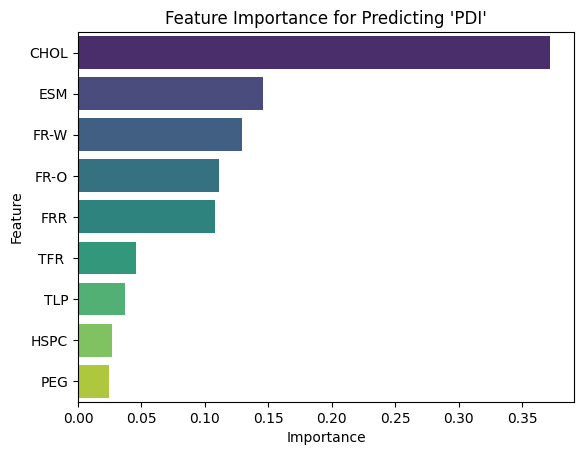

In [ ]:
rf_pdi = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pdi.fit(X, y_pdi)
feature_importances_pdi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_pdi.feature_importances_
}).sort_values(by='Importance', ascending=False)
sns.barplot(data=feature_importances_pdi, x='Importance', y='Feature',
            hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title("Feature Importance for Predicting 'PDI'")
plt.show()


In [ ]:
model_size = LinearRegression()
rfe_size = RFE(model_size, n_features_to_select=5)
rfe_size.fit(X, y_size)
selected_features_size = X.columns[rfe_size.support_]
print("Top Features for 'Size':", selected_features_size)


Top Features for 'Size': Index(['HSPC', 'PEG', 'TFR ', 'FR-O', 'FR-W'], dtype='object')


In [ ]:
model_pdi = LinearRegression()
rfe_pdi = RFE(model_pdi, n_features_to_select=5)
rfe_pdi.fit(X, y_pdi)
selected_features_pdi = X.columns[rfe_pdi.support_]
print("Top Features for 'PDI':", selected_features_pdi)


Top Features for 'PDI': Index(['HSPC', 'PEG', 'TFR ', 'FR-O', 'FR-W'], dtype='object')


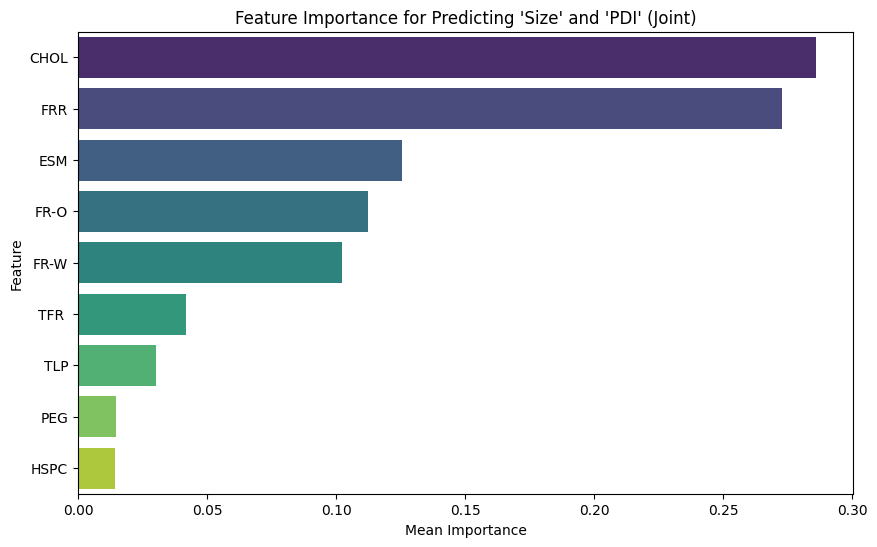

In [ ]:
numeric_data = data.select_dtypes(include=['float64', 'int64']).dropna()
X = numeric_data.drop(columns=['SIZE', 'PDI'])
y = numeric_data[['SIZE', 'PDI']]
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf.fit(X, y)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Size': rf.estimators_[0].feature_importances_,
    'Importance_PDI': rf.estimators_[1].feature_importances_
})
feature_importances['Mean Importance'] = feature_importances[['Importance_Size', 'Importance_PDI']].mean(axis=1)
feature_importances = feature_importances.sort_values(by='Mean Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Mean Importance', y='Feature',
            hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title("Feature Importance for Predicting 'Size' and 'PDI' (Joint)")
plt.show()

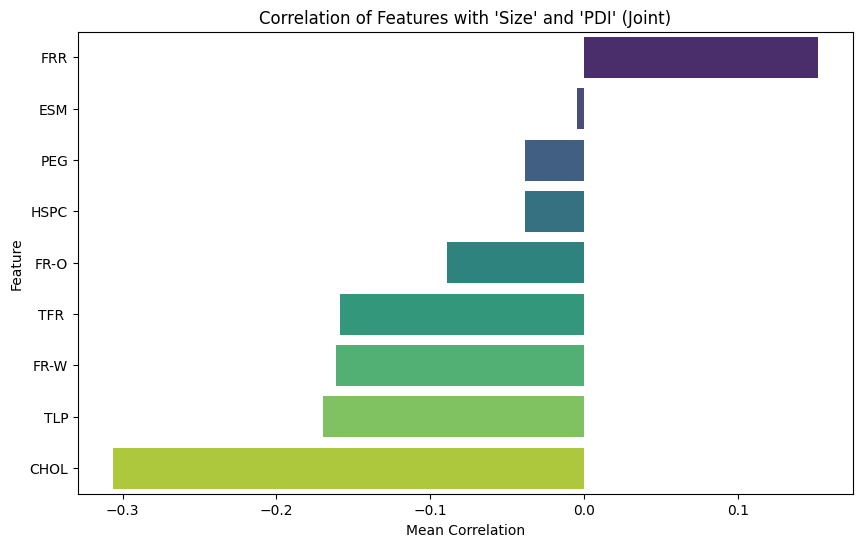

In [ ]:
correlation_matrix = numeric_data.corr()
joint_correlation = correlation_matrix[['SIZE', 'PDI']].drop(index=['SIZE', 'PDI']).mean(axis=1)
joint_correlation_df = joint_correlation.reset_index()
joint_correlation_df.columns = ['Feature', 'Mean Correlation']
joint_correlation_df = joint_correlation_df.sort_values(by='Mean Correlation', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=joint_correlation_df, x='Mean Correlation', y='Feature',
            hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title("Correlation of Features with 'Size' and 'PDI' (Joint)")
plt.show()